## Realized Volatility - Long Strategy Backtest

Preston Fisk | prestonfisk99@gmail.com | www.github.com/prestonf99

### Imports & Data Setup

In [1]:
import yfinance as yf 
import numpy as np
import pandas as pd
from pylab import mpl, plt
plt.style.use('seaborn-v0_8')
from datetime import datetime, timedelta
days = 1200 #You Choose the start date
end_date = datetime.now() #The exercise ends today
start_date = end_date - timedelta(days=days) #Calculating the start date for yFinance API.

In [2]:
ticker = yf.Ticker('^GSPC') #S&P 500
ticker_ = yf.Ticker('^VIX') #VIX
spx = ticker.history(interval='1d', start=start_date,
                     end=end_date) #Data Retrieval using yFinance API
vix = ticker_.history(interval='1d', start=start_date,
                     end=end_date)
spx = spx.drop(['Dividends', 'Volume', 'Stock Splits'], axis=1) #Cleaning up unnecessary columns
vix = vix.drop(['Dividends', 'Volume', 'Stock Splits'], axis=1)
spx.index = spx.index.date #Reindexing the Dataframe
vix.index = vix.index.date
spx = spx.rename(columns={'Close': 'SPX_Close'})
vix = vix.rename(columns={'Close': 'VIX_Close'})
data = spx[['SPX_Close']].join(vix[['VIX_Close']]) #New dataframe with only S&P & VIX Closing Prices

In [3]:
data['return'] = np.log(data['SPX_Close'] / 
                        data['SPX_Close'].shift(1)) #Calculating S&P Returns
data['std'] = data['return'].rolling(window=30).std() #30D Rolling standard Deviation
data['Vol'] = data['std'] * np.sqrt(252) #Annualized. This is the Close-Close Volatility Estimator Calculation
data['VRP'] = data['VIX_Close'] - (data['Vol'] * 100) #Volatility Risk Premium Calculation (VIX - Realized Volatility)
data.dropna(inplace=True)

In [4]:
data.head(1) #New Dataframe With the relevant information

,SPX_Close,VIX_Close,return,std,Vol,VRP
2021-05-24,4197.049805,18.4,0.009862,0.00853,0.135416,4.858362


### Parameters

In [5]:
data['rpmean'] = data['VRP'].rolling(window=90).mean() #Rolling mean of the VRP
data['rpstd'] = data['rpmean'].std() #Standard deviation of the rolling Mean
data['upper_std'] = data['rpmean'] + (data['rpstd'] * 3) #3σ Upper & lower bands for this exercise. Feel free to play with it!
data['lower_std'] = data['rpmean'] + (data['rpstd'] * -3)
data['Position'] = 0 #Starting Position is flat. 
position = 0

### Implementing Position Logic

In [6]:
for index, row in data.iterrows():
    if position == 0: #When Position is 0
        if row['VRP'] > row['upper_std']: #And the Volatility risk premium is higher than the threshold
            position = 1 #Change Position to Long
            print(f"Going long on {index} with VRP {row['VRP']:.2f} and upper std of {row['upper_std']:.2f} at {row['SPX_Close']:.0f}") #Notify the user
    elif position == 1: #If we're already long
        if row['VRP'] <= row['lower_std']: #The risk premium is below the lower band
            position = 0 #Flatten Position
            print(f"Flattening on {index} with VRP {row['VRP']:.2f} and lower std {row['lower_std']:.2f} at {row['SPX_Close']:.0f}")

    data.at[index, 'Position'] = position



Going long on 2021-11-26 with VRP 19.02 and upper std of 13.94 at 4595
Flattening on 2021-12-22 with VRP 1.21 and lower std 1.36 at 4697
Going long on 2022-01-24 with VRP 13.65 and upper std of 12.92 at 4410
Flattening on 2022-03-18 with VRP -0.24 and lower std 0.44 at 4463
Going long on 2022-04-26 with VRP 12.13 and upper std of 10.68 at 4175
Flattening on 2022-05-17 with VRP -2.00 and lower std -1.63 at 4089
Going long on 2022-09-23 with VRP 7.27 and upper std of 6.83 at 3693
Flattening on 2022-11-10 with VRP -7.19 and lower std -4.16 at 3956
Going long on 2023-02-21 with VRP 6.43 and upper std of 6.29 at 3997


### Evaluating Strategy Performance

In [7]:
data['Strategy'] = ((1 + (data['return']*data['Position'])).cumprod() -1) #Strategy's Returns
data['Benchmark'] = ((1 + data['return']).cumprod() - 1) #Index's Cumulative Return

In [8]:
def evaluate_strategy(data):
    print("BACKTEST RESULTS")
    print("================================")
    print(f"The benchmark's return was {data['Benchmark'].iloc[-1] * 100:.2f}%") #Display benchmark returns
    print(f"The stragegy's return was {data['Strategy'].iloc[-1] * 100:.2f}%") #Display Strategy returns
    if data['Benchmark'].iloc[-1] > data['Strategy'].iloc[-1]:
        print(f"The strategy underperformed the benchmark by {(data['Benchmark'].iloc[-1] - data['Strategy'].iloc[-1]) * 100:.2f}%")
        #Measuring Performance Differences
    elif data['Strategy'].iloc[-1] > data['Benchmark'].iloc[-1]:
        print(f"The strategy outperformed the benchmark by {(data['Strategy'].iloc[-1] - data['Benchmark'].iloc[-1]) * 100:.2f}%")

In [9]:
evaluate_strategy(data)

BACKTEST RESULTS
The benchmark's return was 25.90%
The stragegy's return was 20.95%
The strategy underperformed the benchmark by 4.94%


### Plotting the Backtest

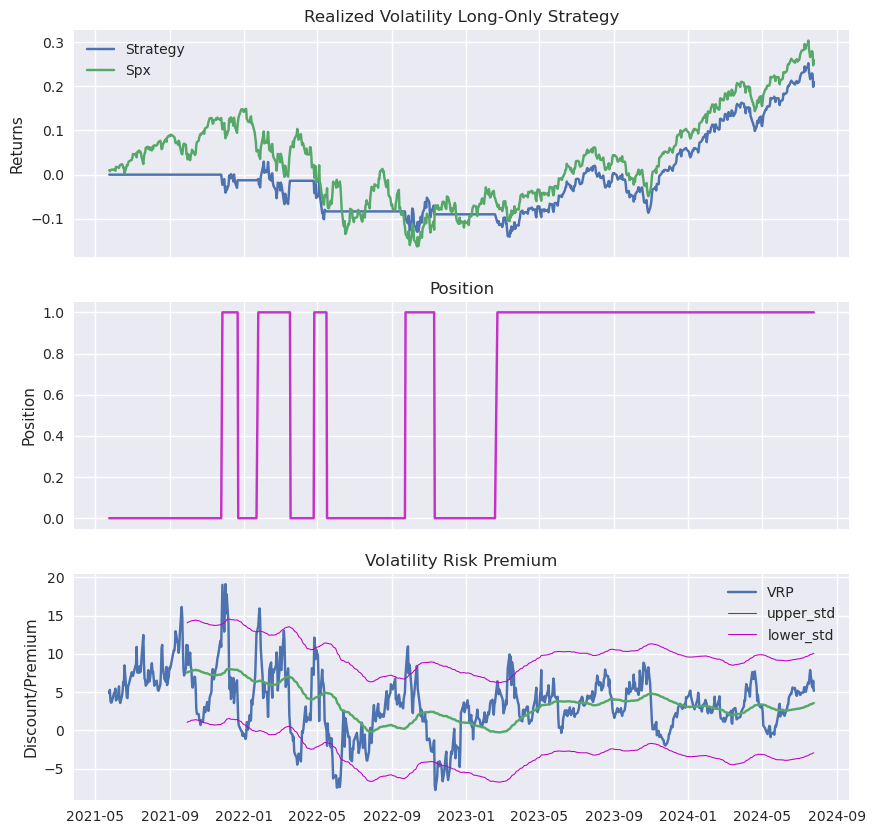

In [11]:
fig, ax1 = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
plt.subplot(311)
plt.plot(data['Strategy'], label='Strategy')
plt.plot(((1 + data['return']).cumprod() - 1), label='Spx')
plt.legend()
plt.title('Realized Volatility Long-Only Strategy')
plt.ylabel('Returns')
plt.subplot(312)
plt.plot(data['Position'], color='m', alpha=0.8, label='Position')
plt.title('Position')
plt.ylabel('Position')
plt.subplot(313)
plt.plot(data['VRP'], label='VRP')
plt.plot(data['rpmean']) #label='VRP-Mean', lw=0.75)
plt.plot(data['upper_std'], label='upper_std', color='m', lw=0.75)
plt.plot(data['lower_std'], color='m', lw=0.75, label='lower_std')
plt.legend()
plt.title('Volatility Risk Premium')
plt.ylabel('Discount/Premium');